In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import matplotlib.pyplot as plt
#import torch
from modelling_fctns import double_logistic, normalized_difference
import data_cleaning

import libtlda.tca

import adapt.feature_based

import cv2
from PIL import Image
#

In [41]:
import skfda
from skfda.misc.hat_matrix import (
    KNeighborsHatMatrix,
    LocalLinearRegressionHatMatrix,
    NadarayaWatsonHatMatrix,
)
from skfda import FDataGrid
from skfda.misc.kernels import uniform
from skfda.preprocessing.smoothing import KernelSmoother
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch

In [109]:
def max_in_region(df):
    if len(df) == 0:
        return df
    else:
        return df.loc[[df['NDVI'].idxmax()]]
    
def max_value_int(df, window_size=8):
    '''Returns the maximum value and location of maximum value in windows of size window_size'''
    #df.loc[:, 'formatted_time'] = pd.DatetimeIndex(df['formatted_time'])
    if len(df) == 0:
        return None
    else:
        return df.infer_objects().groupby(pd.Grouper(key='formatted_time',freq=f'{window_size}D'))[df.columns].apply(max_in_region, include_groups=True)
    
def map_max_value_int(df, window_size = 8, bands = ['NDVI']):
    '''Returns the maximum value and location of maximum value in windows of size window_size'''
    df.loc[:, 'formatted_time'] = pd.DatetimeIndex(df['formatted_time'])
    for latlon_index, latlon in enumerate(df.loc[:, ['lat', 'lon']].drop_duplicates().values):
        #print(latlon)
        df_latlon = df.loc[(df['lat'] == latlon[0]) & (df['lon'] == latlon[1])].dropna()
        #print(len(df_latlon))
        df_max_value_int = max_value_int(df_latlon, window_size)
        #print(len(df_max_value_int))
        if latlon_index == 0:
            df_max_value_int_all = df_max_value_int
        else:
            df_max_value_int_all = pd.concat([df_max_value_int_all, df_max_value_int])
    df_max_value_int_all = df_max_value_int_all.rename(columns = {'formatted_time': 'raw_time'}).reset_index().rename(columns = {'formatted_time': 'time'})
    for band in bands:
        df_max_value_int_all[band] = np.interp(df_max_value_int_all['time'], df_max_value_int_all['raw_time'], df_max_value_int_all[band])
    return df_max_value_int_all

In [111]:
max_value_interpolated = map_max_value_int(ds)

In [ ]:
max_value_interpolated[['NDVI']] = np.interp(max_value_interpolated['time'], max_value_interpolated['formatted_time'], max_value_interpolated[['NDVI']])

In [97]:
max_value_interpolated = max_value_interpolated.rename(columns = {'formatted_time': 'raw_time'}).reset_index().rename(columns = {'formatted_time': 'time'})
max_value_interpolated['NDVI'] = np.interp(max_value_interpolated['time'], max_value_interpolated['raw_time'], max_value_interpolated['NDVI'])

In [98]:
max_value_interpolated

,index,time,level_1,Unnamed: 0,Time,lat,lon,Stations_Id,median sur_refl_b01,median sur_refl_b02,median sur_refl_b03,median sur_refl_b04,raw_time,SOS,EOS,NDVI
0,0,2021-01-06 00:00:00+00:00,2299,372,1609977600000,-1.0,35.65,0,644.0,1878.0,325.0,592.0,2021-01-07 00:00:00+00:00,145.0,331.0,0.489294
1,1,2021-01-14 00:00:00+00:00,2302,385,1611100800000,-1.0,35.65,0,703.0,2160.0,367.0,690.0,2021-01-20 00:00:00+00:00,145.0,331.0,0.499855
2,2,2021-01-22 00:00:00+00:00,2304,390,1611532800000,-1.0,35.65,0,650.0,2181.0,329.0,624.0,2021-01-25 00:00:00+00:00,145.0,331.0,0.521663
3,3,2021-01-30 00:00:00+00:00,2310,397,1612137600000,-1.0,35.65,0,725.0,2235.0,353.0,627.0,2021-02-01 00:00:00+00:00,145.0,331.0,0.518896
4,4,2021-02-07 00:00:00+00:00,2316,408,1613088000000,-1.0,35.65,0,583.0,2043.0,306.0,581.0,2021-02-12 00:00:00+00:00,145.0,331.0,0.535141
5,5,2021-02-15 00:00:00+00:00,2320,417,1613865600000,-1.0,35.65,0,589.0,2240.0,322.0,616.0,2021-02-21 00:00:00+00:00,145.0,331.0,0.565185
6,6,2021-02-23 00:00:00+00:00,2322,422,1614297600000,-1.0,35.65,0,582.0,2298.0,299.0,596.0,2021-02-26 00:00:00+00:00,145.0,331.0,0.588492
7,7,2021-03-03 00:00:00+00:00,2328,431,1615075200000,-1.0,35.65,0,563.0,2518.0,315.0,620.0,2021-03-07 00:00:00+00:00,145.0,331.0,0.617334
8,8,2021-03-11 00:00:00+00:00,2331,436,1615507200000,-1.0,35.65,0,531.0,2430.0,292.0,537.0,2021-03-12 00:00:00+00:00,145.0,331.0,0.639977
9,9,2021-03-19 00:00:00+00:00,2338,447,1616457600000,-1.0,35.65,0,540.0,2267.0,315.0,559.0,2021-03-23 00:00:00+00:00,145.0,331.0,0.624735


In [58]:
fd['time'] = pd.DatetimeIndex(fd['time']).dayofyear


In [60]:
fd = FDataGrid(
    grid_points=fd['time'],
    data_matrix=np.array([fd['NDVI'].values]),
)

In [34]:
latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().sample(1)
ds_station = ds.loc[(ds['lat'] == latlon['lat'].values[0]) & (ds['lon'] == latlon['lon'].values[0])]
#ds_station = ds.loc[(ds['Stations_Id'] == station)]
ds_year = ds_station.loc[pd.DatetimeIndex(ds_station['formatted_time']).year  == 2021]
max_value_interpolated = data_cleaning.map_max_value_int(ds_year, window_size=8)
fd = max_value_interpolated[['NDVI', 'formatted_time']]
fd = fd.rename(columns = {'formatted_time':'time'}).reset_index().drop(['formatted_time', 'level_1'], axis = 1)

In [91]:
os = NadarayaWatsonHatMatrix(bandwidth=60)
fd_os = KernelSmoother(
    kernel_estimator=os,
    output_points=np.arange(10, 350)
)
os_fitted = fd_os.fit_transform(fd)

us = NadarayaWatsonHatMatrix(bandwidth=20)
fd_us = KernelSmoother(
    kernel_estimator=us,
    output_points=np.arange(10, 350)
)
us_fitted = fd_us.fit_transform(fd)

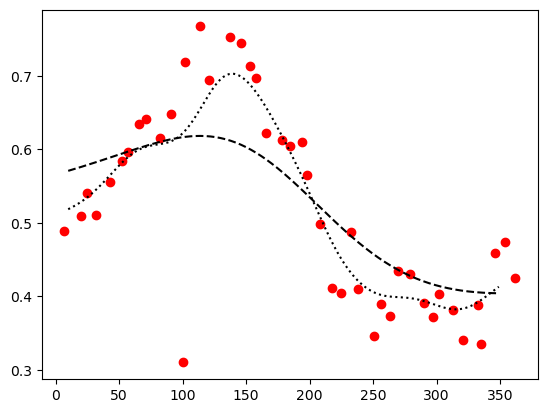

In [93]:
fig, ax = plt.subplots()
ax.plot(fd_os.output_points.squeeze(), os_fitted.data_matrix.squeeze(), color = 'black', linestyle='--')
ax.plot(fd_us.output_points.squeeze(), us_fitted.data_matrix.squeeze(), color = 'black', linestyle=':')
ax.scatter(fd.grid_points, fd.data_matrix.squeeze(), color='red')

In [3]:
def WC_SOS(lon, lat):
    y = np.int32((2*lat) + 286/2)
    x = np.int32((2*lon) + 720/2)
    photo = Image.open("Useful_Files\\M1_SOS_WGS84.tif")
    data = np.array(photo)
    return data[y, x]

In [4]:
def WC_EOS(lon, lat):
    y = np.int32((2*lat) + 286/2)
    x = np.int32((2*lon) + 720/2)
    photo = Image.open("Useful_Files\\M1_EOS_WGS84.tif")
    data = np.array(photo)
    return data[y, x]

In [5]:
WC_SOS(np.array([0, 0]), np.array([0, 0]))

array([158., 158.], dtype=float32)

In [6]:
def randomly_sample_windows(df, m_window_size = 6):
    # First sample a location:
    latlon = df.loc[:, ['lat', 'lon']].drop_duplicates().sample(1)
    ds_loc = df.loc[(df['lat'] == latlon['lat'].values[0]) & (df['lon'] == latlon['lon'].values[0])]
    #print(len(ds_loc))
    #Then sample a time window:
    if len(ds_loc) < m_window_size:
        return None
    else:
        start = np.random.randint(len(ds_loc) - m_window_size)
        return ds_loc[start:start+m_window_size]

In [7]:
def make_df_samples(df, sample_number = 100, m_window_size = 5, seed = 0):
    '''Randomly sample windows of length m_window_size from the maximum value composited time series in df'''
    df_time_adjust = df.rename(columns={'formatted_time': 'actual_time'}).reset_index()
    df_time_adjust['time from edge'] = (df_time_adjust['actual_time'] - df_time_adjust['formatted_time']).dt.days
    np.random.seed(seed)
    first = True
    for count in range(sample_number):
        sample = randomly_sample_windows(df_time_adjust, m_window_size=m_window_size)
        #print(count)
        if sample is None:
            continue
        else:
            sample_array = xr.Dataset.from_dataframe(sample.loc[:, ['median sur_refl_b03', 'median sur_refl_b04', 'NDVI', 'time from edge']])
            sample_array = sample_array.assign({"indexer": (("index"), np.arange(1, 6))}).set_index({'index': 'indexer'})
        if first == True:
            full_array = sample_array.expand_dims('sample')
            first = False
        else:
            full_array = xr.concat([full_array, sample_array.expand_dims('sample')], dim='sample')
    return full_array

In [8]:
def make_tensor_from_timeseries(df, sample_number = 100, m_window_size = 5, seed = 0, format_choice = 'pytorch'):
    '''Randomly sample windows of length m_window_size from the maximum value composited time series in df'''
    df_time_adjust = df.rename(columns={'formatted_time': 'actual_time'}).reset_index()
    df_time_adjust['time from edge'] = (df_time_adjust['actual_time'] - df_time_adjust['formatted_time']).dt.days
    np.random.seed(seed)
    first = True
    for count in range(sample_number):
        sample = randomly_sample_windows(df_time_adjust, m_window_size=m_window_size)
        #print(count)
        if sample is None:
            continue
        else:
            flattened_sample = np.array([sample.loc[:, ['median sur_refl_b03', 'median sur_refl_b04', 'NDVI', 'time from edge']].values.flatten()])
            #print(flattened_sample.shape)
            if first == True:
                tensor =flattened_sample
                first = False
                #print('First')
            else:
                tensor = np.concatenate([tensor, flattened_sample], axis = 0)
    #print(tensor)
    #print(torch.tensor(tensor))
    if format_choice == 'pytorch':
        return torch.tensor(tensor)
    else:
        return tensor

In [9]:
def add_SOS_to_df(df):
    df['SOS'] = WC_SOS(df['lon'], df['lat'])
    return df

In [10]:
def add_EOS_to_df(df):
    df['EOS'] = WC_EOS(df['lon'], df['lat'])
    return df

In [101]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\satdata0.csv')
ds = add_SOS_to_df(ds)
ds = add_EOS_to_df(ds)
ds['NDVI'] = normalized_difference(ds['median sur_refl_b02'], ds['median sur_refl_b01'])
max_value_interpolated = data_cleaning.map_max_value_int(ds, window_size=8)
#array_input = make_df_samples(max_value_interpolated, sample_number = 1000, m_window_size = 5)
#sampled_locs_input = make_tensor_from_timeseries(max_value_interpolated, sample_number = 100, m_window_size = 5, format_choice = 'numpy')

ValueError: object too deep for desired array

In [12]:
ds2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0.csv')
ds2 = add_SOS_to_df(ds2)
ds2 = add_EOS_to_df(ds2)
ds2['NDVI'] = normalized_difference(ds['median sur_refl_b02'], ds['median sur_refl_b01'])
max_value_interpolated2 = data_cleaning.map_max_value_int(ds2, window_size=8)
array_input2 = make_df_samples(max_value_interpolated2, sample_number = 1000, m_window_size = 5)
sampled_locs_input2 = make_tensor_from_timeseries(max_value_interpolated2, sample_number = 100, m_window_size = 5, format_choice = 'numpy')

In [7]:
def autocorrelation_matrix(ds, variable = 'NDVI', index_coord = 'index'):
    X = (ds[variable] - ds[variable].mean(dim='sample')).values
    return np.corrcoef(X.T)

Text(0.5, 0.98, 'Correlation between times in a window of NDVI timeseries')

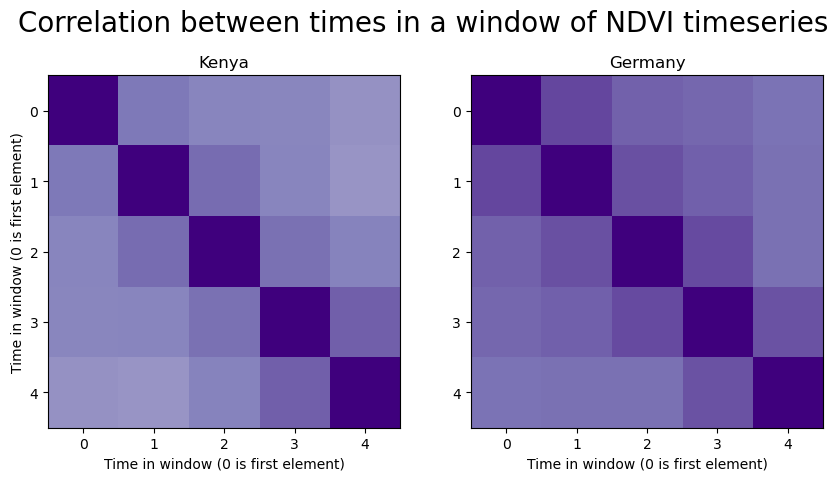

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(autocorrelation_matrix(array_input, variable = 'NDVI', index_coord = 'index'), vmin = 0, vmax = 1, cmap = 'Purples')
axs[0].set_ylabel('Time in window (0 is first element)')
axs[0].set_xlabel('Time in window (0 is first element)')
axs[1].imshow(autocorrelation_matrix(array_input2, variable = 'NDVI', index_coord = 'index'), vmin = 0, vmax = 1, cmap = 'Purples')
axs[1].set_xlabel('Time in window (0 is first element)')
axs[0].set_title('Kenya')
axs[1].set_title('Germany')
fig.suptitle('Correlation between times in a window of NDVI timeseries', fontsize = 20)

In [193]:
ds.loc[:, ['lat', 'lon']].drop_duplicates()

,lat,lon
0,-1.00,35.10
58,-1.00,35.25
59,-1.00,35.30
116,-1.00,35.45
642,-1.00,35.50
1153,-1.00,35.55
1649,-1.00,35.60
2137,-1.00,35.65
2627,-1.00,35.70
3107,-1.00,35.75


3 lat    -1.0
lon    35.2
Name: 1556, dtype: float64 2021-04-24 00:00:00+00:00
4 lat    -1.00
lon    35.25
Name: 2093, dtype: float64 2021-01-18 00:00:00+00:00
6 lat    -1.00
lon    35.35
Name: 3213, dtype: float64 2021-03-07 00:00:00+00:00


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))


7 lat    -1.0
lon    35.4
Name: 3720, dtype: float64 2021-03-23 00:00:00+00:00
8 lat    -1.00
lon    35.45
Name: 4249, dtype: float64 2021-03-25 00:00:00+00:00
9 lat    -1.0
lon    35.5
Name: 4775, dtype: float64 2021-03-11 00:00:00+00:00
10 lat    -1.00
lon    35.55
Name: 5291, dtype: float64 2021-04-28 00:00:00+00:00


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_6576\3784479479.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)


12 lat    -1.00
lon    35.65
Name: 6276, dtype: float64 2021-05-14 00:00:00+00:00
145.0
331.0


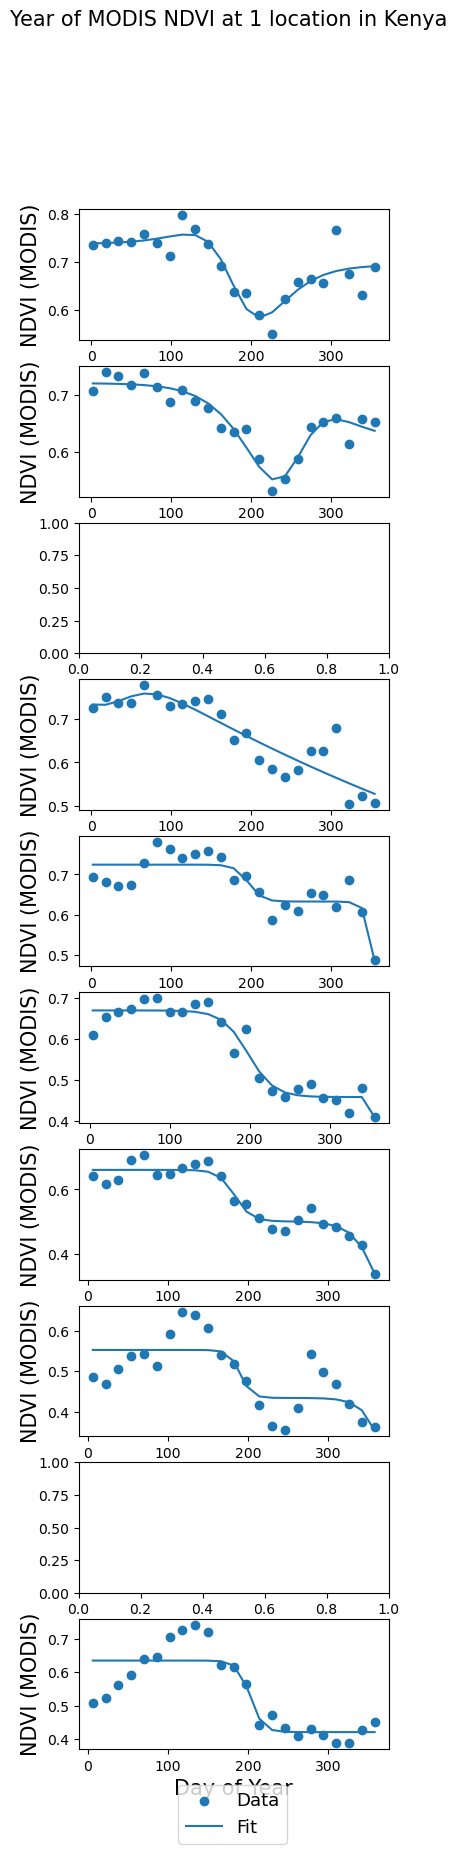

In [204]:
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0_GER.csv')
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\NoWCsatdata0.csv')#_KEN
ds['NDVI'] = (ds['median sur_refl_b02'] - ds['median sur_refl_b01'])/(ds['median sur_refl_b02'] + ds['median sur_refl_b01'])
#station = ds['Stations_Id'].unique()[0]



font_size = 15
fig, axs = plt.subplots(10, 1, figsize = (4, 20))
shift = 3
for location_index in [3, 4, 6, 7, 8, 9, 10, 12]:#[3, 4, 5, 6, 7, 8, 9, 10, 12]:#[20, 21, 23, 27]:# range(shift, shift + 10):#[3, 5, 6, 7, 9, 10, 12]:#:
    latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().iloc[location_index]
    ds_station = ds.loc[(ds['lat'] == latlon['lat']) & (ds['lon'] == latlon['lon'])]
    #ds_station = ds.loc[(ds['Stations_Id'] == station)]
    ds_year = ds_station.loc[pd.DatetimeIndex(ds_station['formatted_time']).year  == 2021]
    max_value_interpolated = map_max_value_int(ds_year, window_size=16) #data_cleaning.
    print(location_index, latlon, max_value_interpolated['time'].loc[max_value_interpolated['NDVI'].idxmax()])
    Times = pd.DatetimeIndex(max_value_interpolated['time']).dayofyear.values
    NDVIs = max_value_interpolated['NDVI'].values
    params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)
    axs[location_index - shift].scatter(Times, NDVIs, label = 'Data')
    axs[location_index - shift].plot(Times, double_logistic(Times/365, *params), label = 'Fit')
    axs[location_index - shift].set_xlabel('Day of Year', fontsize = font_size)
    axs[location_index - shift].set_ylabel('NDVI (MODIS)', fontsize = font_size)
fig.suptitle('Year of MODIS NDVI at 1 location in Kenya', fontsize = font_size)
axs[location_index - 3].legend(fontsize = font_size - 2, bbox_to_anchor=(0.7, -0.2))
print(WC_SOS(latlon['lon'], latlon['lat']))
print(WC_EOS(latlon['lon'], latlon['lat']))

In [112]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0.csv')
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\satdata0.csv')
ds['NDVI'] = (ds['median sur_refl_b02'] - ds['median sur_refl_b01'])/(ds['median sur_refl_b02'] + ds['median sur_refl_b01'])
#station = ds['Stations_Id'].unique()[0]
latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().sample(1)
ds_station = ds.loc[(ds['lat'] == latlon['lat'].values[0]) & (ds['lon'] == latlon['lon'].values[0])]
#ds_station = ds.loc[(ds['Stations_Id'] == station)]
ds_year = ds_station.loc[pd.DatetimeIndex(ds_station['formatted_time']).year  == 2021]
max_value_interpolated = data_cleaning.map_max_value_int(ds_year, window_size=8)
Times = pd.DatetimeIndex(max_value_interpolated['formatted_time']).dayofyear.values
NDVIs = max_value_interpolated['NDVI'].values

params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))


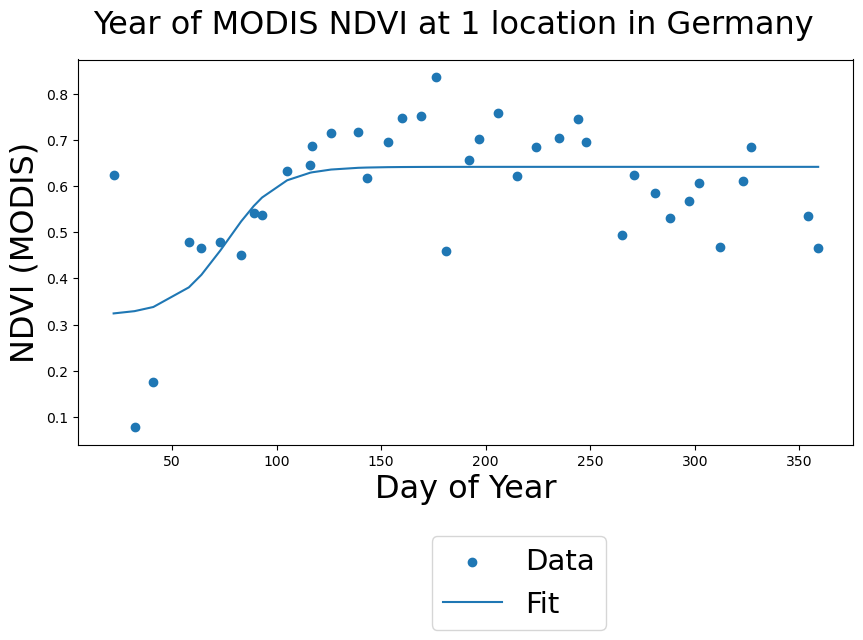

In [113]:
font_size = 23
fig, ax = plt.subplots(figsize = (10, 5))
ax.scatter(Times, NDVIs, label = 'Data')
ax.plot(Times, double_logistic(Times/365, *params), label = 'Fit')
ax.set_xlabel('Day of Year', fontsize = font_size)
ax.set_ylabel('NDVI (MODIS)', fontsize = font_size)
fig.suptitle('Year of MODIS NDVI at 1 location in Germany', fontsize = font_size)
ax.legend(fontsize = font_size - 2, bbox_to_anchor=(0.7, -0.2))

In [53]:
X = (array_input2['NDVI'] - array_input2['NDVI'].mean(dim='sample')).values
np.corrcoef(X.T)

array([[1.        , 0.83662139, 0.74261934, 0.73125136, 0.70882541],
       [0.83662139, 1.        , 0.80827924, 0.75418058, 0.65950048],
       [0.74261934, 0.80827924, 1.        , 0.76833473, 0.60545472],
       [0.73125136, 0.75418058, 0.76833473, 1.        , 0.71443907],
       [0.70882541, 0.65950048, 0.60545472, 0.71443907, 1.        ]])

In [37]:
ds2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0.csv')
ds2['NDVI'] = normalized_difference(ds['median sur_refl_b02'], ds['median sur_refl_b01'])
max_value_interpolated2 = data_cleaning.map_max_value_int(ds2, window_size=8)
sampled_locs_input2 = make_tensor_from_timeseries(max_value_interpolated2, sample_number = 100, m_window_size = 5, format_choice = 'numpy')

In [40]:
sampled_locs_input.shape

(95, 20)

In [51]:
np.mean(sampled_locs_input, axis=0).shape

(20,)

In [52]:
X = sampled_locs_input - np.mean(sampled_locs_input, axis=0)
Z = sampled_locs_input2 - np.mean(sampled_locs_input2, axis=0)

In [63]:
X.shape

(95, 20)

In [65]:
TCA = libtlda.tca.TransferComponentClassifier(kernel_type='sigmoid', num_components = 3)
C, K = TCA.transfer_component_analysis(X, Z)

Adding regularization: 1e-06
Adding regularization: 1e-05
Adding regularization: 0.0001
Adding regularization: 0.001
Adding regularization: 0.01
Adding regularization: 0.1
Adding regularization: 1
Adding regularization: 10
Adding regularization: 100


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\libtlda\tca.py:108: RuntimeWarning: overflow encountered in exp
  return 1./(1 + np.exp(np.dot(X, Z.T)))


In [70]:
np.corrcoef(X.T).shape

(20, 20)

In [17]:
adapter = adapt.feature_based.fMMD()
X_emb.shape
adapter.transform(np.array([[1 for count in range(5)]]))

In [64]:
C.shape

(195, 3)

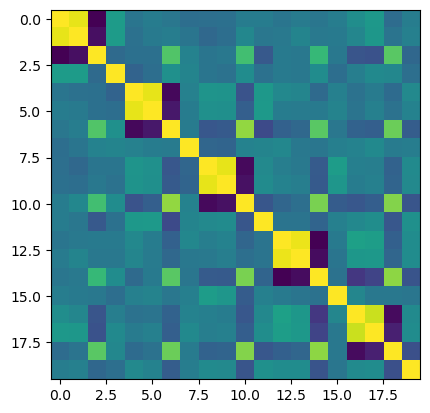

In [71]:
plt.imshow(np.corrcoef(X.T))